## Linear regression

### Part A

$f(\beta) = \sum\limits_{i=1}^{N} \{\frac {\omega_i}{2} (y_i - x_i \beta)^2\}$

$= (y - X \beta)^T \omega (y - X \beta)$

$= y^T \omega y - 2 y^T \omega X \beta + \beta^T X^T \omega X \beta$

Therefore,

$\frac {\partial f{\beta}}{\partial \beta} = 0 - 2 y^T \omega X + 2 \beta^T X^T \omega X = 0$

$X^T \omega y = (X^T \omega X) \beta$

### Part B

#### pseudo code for my method (Cholesky Factorization)


$X^T W X = L L^T $

```
A = X^T %*% W %*% X
b = X^T %*% W %*% y
L %*% L^T = X^T * W * X  # decomposation
beta = L^(-1) %*% (L^T)^(-1) %*% b
```

### Part C

In [23]:
# generate simulated data
P = 1000  # variable size
N = 2000  # sample size
set.seed(1)
beta = rep(1,P)
X = matrix(rnorm(N*P), nrow=N)
y = X%*%beta + rnorm(N,sd=0.05)
W = diag(rep(1, N))

In [24]:
# import inversion and Cholesky methods
source("~/Box Sync/PhDCourses/SDS385Statistical_models_for_big_data/SDS385/solutions/exercises01/factorization.R")
library('microbenchmark')
library('ggplot2')

In [25]:
# experiment on inversion method
beta.inv = inversion.method(X, y, W)


In [26]:
# experiment on Cholesky method
beta.chol = Cholesky.method(X, y, W)


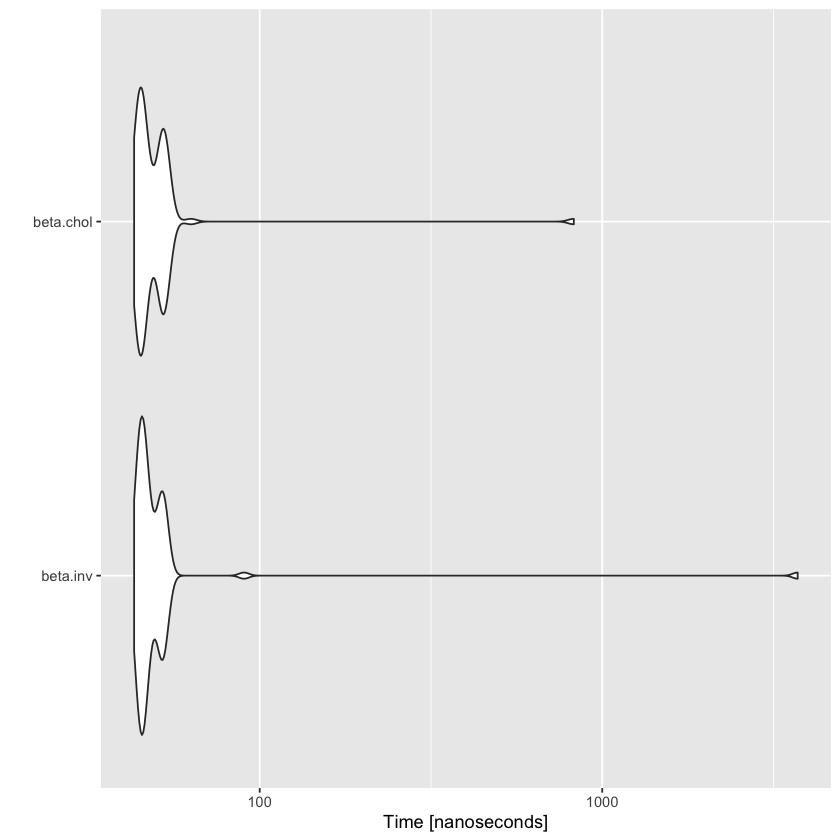

In [27]:
# timing
time = microbenchmark(beta.inv, beta.chol, times=100)
autoplot(time)

### Part D

In [28]:
# generate sparse data
P = 1000  # variable size
N = 2000  # sample size
sparse = 0.1 # dense of sparse matrix
set.seed(1)
beta = rep(1,P)
X = matrix(rnorm(N*P), nrow=N)
mask = matrix(rbinom(N*P, 1, sparse), nrow=N)
X = mask * X
y = X%*%beta + rnorm(N,sd=0.05)
W = diag(rep(1, N))

In [29]:
# experiment on inversion method for sparse data
beta.inv = inversion.method(X, y, W)

In [30]:
# experiment on Cholesky method for sparse data
beta.chol = Cholesky.method(X, y, W)

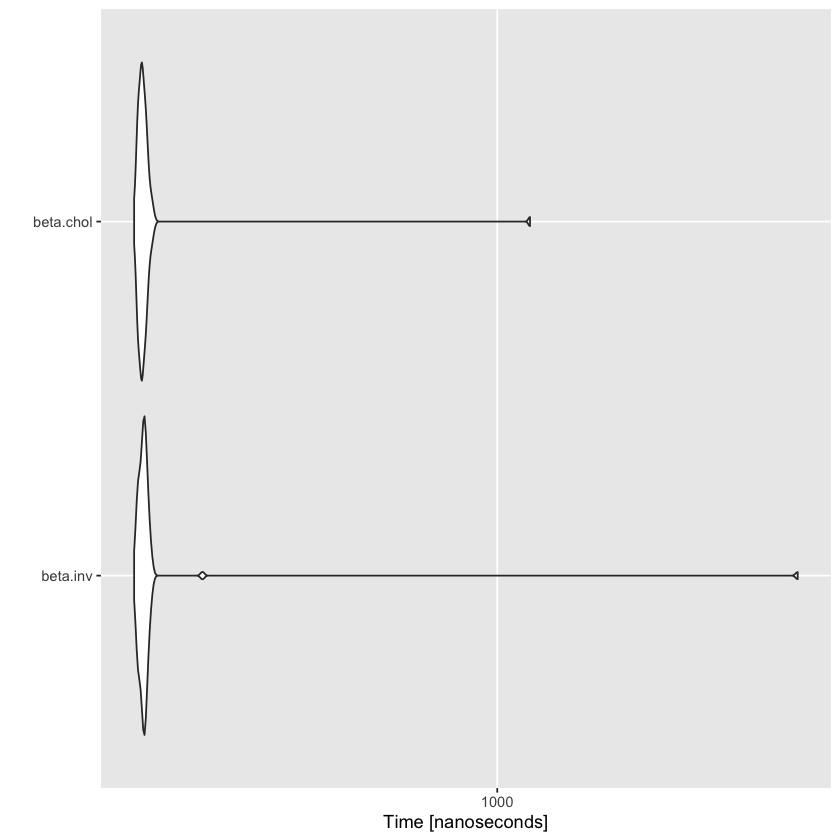

In [31]:
# timing
time = microbenchmark(beta.inv, beta.chol, times=100)
autoplot(time)

## Generalized linear regression

### Part A

Negative log likelihood:

$l(\beta) = - log\{\prod\limits_{i=1}^{N} p(y_i | \beta)\}$

$= - log\{\prod\limits_{i=1}^{N} C * \omega_i^{y_i} * (1 - \omega_i)^{m_i - y_i}\}$

$= - \sum\limits_{i=1}^{N} \{logC + y_i * log{\omega_i} + (m_i - y_i)*log(1-\omega_i)\}$

$= - \sum\limits_{i=1}^{N} \{y_i*log\frac{\omega_i}{1-\omega_i} + m_i*log(1-\omega_i) + C \}$

$= - \sum\limits_{i=1}^{N} \{y_i * log\frac{\omega_i}{1-\omega_i} + m_i*log(1-\omega_i) + C\}$

$= - \sum\limits_{i=1}^{N} \{y_i * log e^{x\beta} - m_i * log(1 + e^{x\beta}) \}$

Gradient of the expression:

$\nabla l(\beta) = \frac {\partial l(\beta)}{\partial \beta}$

$= - \sum\limits_{i=1}^{N} \{\frac {y_i}{\omega_i*(1-\omega_i)} - \frac{m_i}{1-\omega_i}\} \frac{\partial \omega_i}{\partial \beta}$

$\frac {\partial \omega_i}{\partial \beta} = \frac {e^{x_i * \beta}*x_i}{(1 + e^{x_i * \beta})^2}$

Therefore,
$\nabla l(\beta) = - \sum\limits_{i=1}^{N} (y_i - m_i*\omega_i)*x_i$
$= - X^T * (y - m*w)$

### Part B

In [21]:
# import functions for gradient descent
source('~/Box Sync/PhDCourses/SDS385Statistical_models_for_big_data/SDS385/solutions/exercises01/gradient_descent.R')

In [22]:
setwd('~/Box Sync/PhDCourses/SDS385Statistical_models_for_big_data/SDS385/data')
# import wdbs.csv data
data <- read.csv('wdbc.csv', header=F)
y.BM <- data[ ,2]
y <- rep(0, length(y.BM))
y[y.BM == "B"] <- 1
y <- as.matrix(y)
x.variables <- as.matrix(data[ , 3:12])
x <- cbind(x.variables, rep(1,dim(x.variables)[1]))
colnames(x) <- NULL

In [24]:
# gradient descent
betas = matrix(1, 11, 1)
GD.results <- gradient.descent(x, y, betas, step.size=0.01, max.iter=10000)

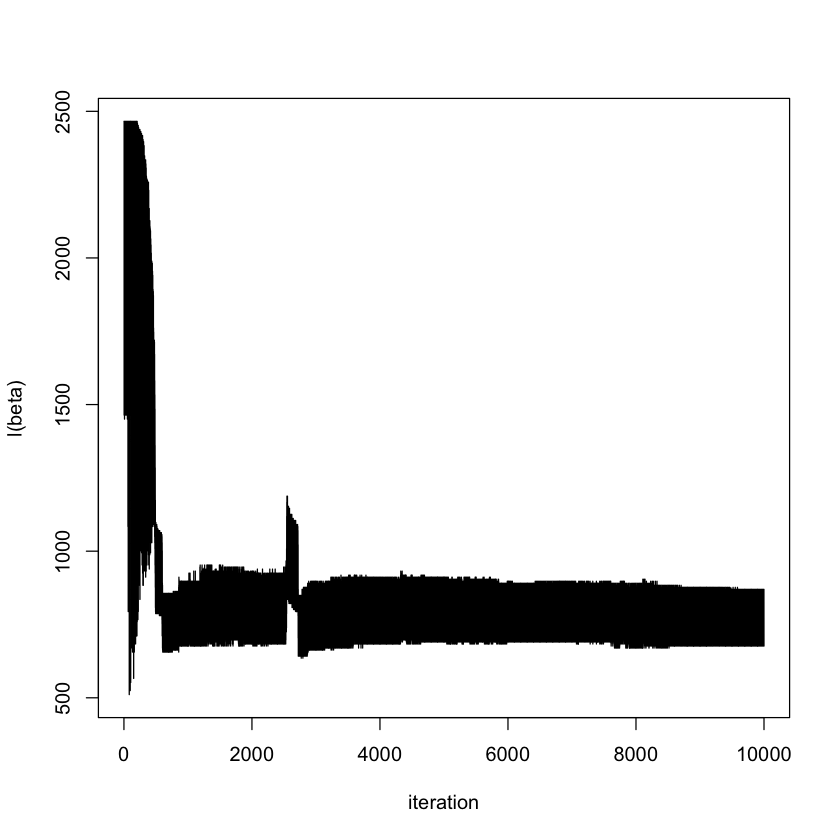

In [26]:
# plot l(beta)
l.beta.GD = GD.results[[2]]
plot(1:10000, l.beta.GD, type='l', xlab='iteration', ylab='l(beta)')

The log likelihood value never converage even with 10k iterations when using `wdbc.csv` data. So next I tried gradient descent algorithm on simulated data --

In [18]:
# generate simulated data
set.seed(666)
x1 = rnorm(1000)  # some continuous variables 
x2 = rnorm(1000)
x = cbind(as.matrix(x1), as.matrix(x2))
x= cbind(x, rep(1,1000))  # add one column for intercept
z = 1 + 2*x[ ,1] + 3*x[ ,2]  # linear combination with a bias
prob = 1/(1+exp(-z))  # pass through an inv-logit function
y = as.matrix(rbinom(1000,1,prob))

In [20]:
# gradient descent on simulated data.
betas = matrix(1, 3, 1)
GD.results <- gradient.descent(x, y, betas, step.size=0.01, max.iter=1000)

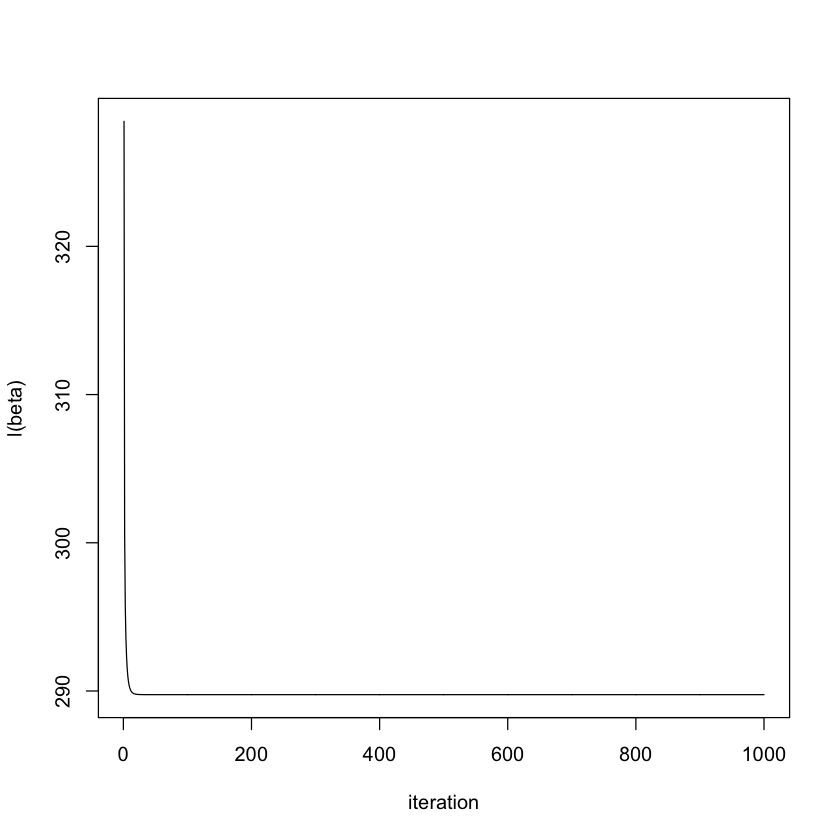

In [17]:
# plot l(beta)
l.beta.GD = GD.results[[2]]
plot(1:1000, l.beta.GD, type='l', xlab='iteration', ylab='l(beta)')

### Part C

The second-order Taylot approximation:

$q(\beta; \beta_0) = l(\beta_0) + (\beta - \beta_0)l'(\beta) + \frac{1}{2} (\beta - \beta_0)^2 l''(\beta)$

Derive $l''(\beta)$ from $l'(\beta)$

$l'(\beta) = - \sum\limits_{i=1}^{N}\{x^T_i (y_i - m_i*\omega_i)\}$

$l''(\beta) = - \sum\limits_{i=1}^{N} \{x^T_i (0-m_i)*\frac{\partial \omega_i}{\partial \beta} \}$

$= \sum \{x^T_i m_i \frac {e^{x_i \beta}}{1 + e^{x_i \beta}} x_i \frac {1}{1+e^{x_i \beta}}\}$

$= \sum \{x^T_i m_i \omega_i (1-\omega_i) x_i\}$

Therefore, $l''(\beta) = X^T S X$, where S is a diagonal matrix with elements $m_i \omega_i (1-\omega_i)$

Thus,

$q(\beta; \beta_0) = l(\beta_0) - (\beta - \beta_0)^T X^T (y - m_i \omega_i) + \frac{1}{2} (\beta - \beta_0)^T X^T S X (\beta - \beta_0)$

$q(\beta; \beta_0) = C - (\beta^T X^T - \beta_0^T X^T) (y - m_i \omega_i) + \frac{1}{2} (\beta^T X^T - \beta_0^T X^T) S (X \beta - X \beta_0)$

$= \frac {1}{2} (X \beta - X \beta_0 - S^{-1}(y - m\omega))^T S (X \beta - X \beta_0 - S^{-1}(y - m\omega)) + C$

Compare the above equation with the original format -- 

$z = X \beta + S^{-1}(y - m\omega)$

$W = S$

### Part D

In [24]:
# import function for Newton's method.
source('~/Box Sync/PhDCourses/SDS385Statistical_models_for_big_data/SDS385/solutions/exercises01/Newton_method.R')

In [25]:
# Newton's method
betas = matrix(0.0001, 11, 1)
newton.results <- my.newton(x, y, betas, max.iter=50)

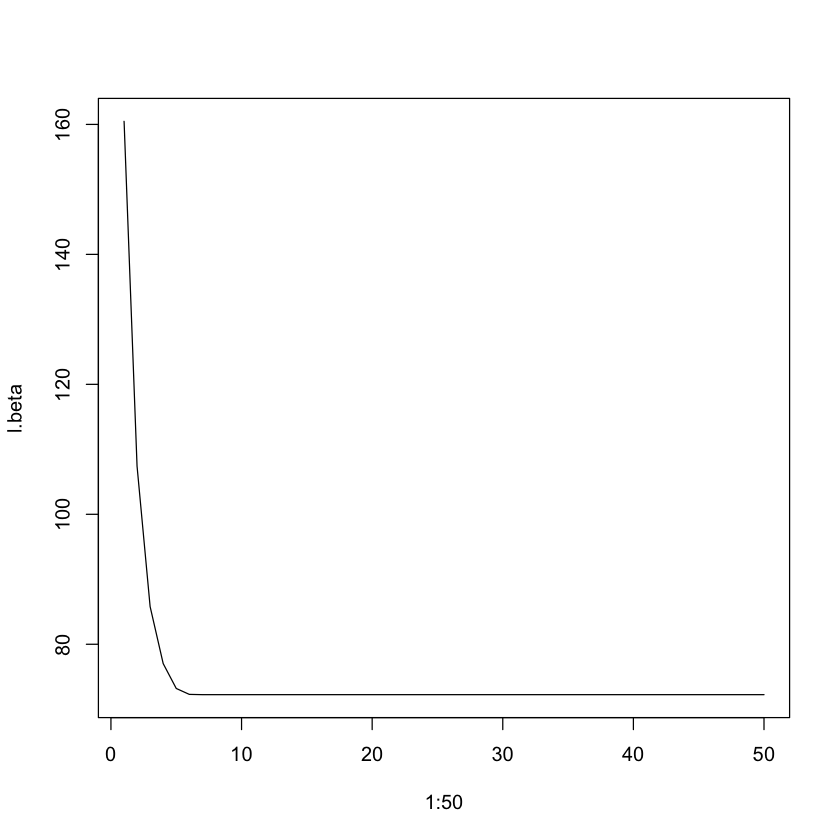

In [26]:
# plot l(beta)
l.beta.newton = newton.results[[2]]
plot(1:50, l.beta.newton, type='l')